In [202]:
import numpy as np
import time
import torch

def ProjectOntoL1Ball(v, b):
    """Projects vector v onto the L1 ball with radius b."""
    if b < 0:
        raise ValueError(f"Radius of L1 ball is negative: {b:.3f}")
    if np.linalg.norm(v, ord=1) <= b:
        return v.copy()
    u = np.sort(np.abs(v))[::-1]  # Descending order
    sv = np.cumsum(u)
    rho = np.where(u > (sv - b) / np.arange(1, len(u) + 1))[0]
    if rho.size == 0:
        theta = 0.0
    else:
        rho_idx = rho[-1]
        theta = (sv[rho_idx] - b) / (rho_idx + 1)
    w = np.sign(v) * np.maximum(np.abs(v) - theta, 0)
    return w

def DBGD(fun_f, grad_f, grad_g, fun_g, TSA, param, x0, a):
    """Dynamic Barrier Gradient Descent algorithm."""
    stepsize = param['stepsize']
    alpha = param['alpha']
    beta = param['beta']
    lambda_ = param['lam']  # Avoid 'lambda' keyword
    maxiter = param['maxiter']
    maxtime = param['maxtime']
    # a = a
    x = x0.copy()
    start_time = time.time()
    iter_count = 0
    f_vec1, g_vec1, time_vec1, acc_vec = [], [], [], []
    d_vec = []
    grad_g_norm_vec = []
    weight_vec = []
    while iter_count <= maxiter:
        # x_prev = x
        iter_count += 1
        # stepsize = stepsize / (a+iter_count ** (1/3))
        grad_f_x = grad_f(x)
        grad_g_x = grad_g(x)
        grad_g_norm_vec.append(np.linalg.norm(grad_g_x))
        # Compute phi and weight (lambda_k)
        g_x = fun_g(x)
        grad_g_sq = np.dot(grad_g_x, grad_g_x)
        phi = grad_g_sq
        
        denominator = grad_g_sq
        if denominator == 0:
            weight = 0.0
        else:
            numerator = phi - np.dot(grad_f_x, grad_g_x)
            weight = max(numerator / denominator, 0.0)
        weight_vec.append(weight)
        v = grad_f_x + weight * grad_g_x
        x = x - stepsize * v
        d_vec.append(np.linalg.norm(v))
        # Projection onto L1 ball
        # x = ProjectOntoL1Ball(x, lambda_)
        
        # Record metrics
        elapsed = time.time() - start_time
        f_vec1.append(fun_f(x))
        g_vec1.append(fun_g(x))
        # time_vec1.append(elapsed)
        time_vec1.append(iter_count)
        acc_vec.append(TSA(x))
        
        # Log progress
        if iter_count % 50000 == 0:
            print(f"Iteration: {iter_count}")
        
        # Check time constraint
        # if elapsed > maxtime:
        #     break
        
        # iter_count += 1
    
    # Convert lists to numpy arrays
    return (
        np.array(f_vec1),
        np.array(g_vec1),
        np.array(time_vec1),
        x,
        np.array(acc_vec),
        np.array(d_vec),
        np.array(grad_g_norm_vec),
        np.array(weight_vec)
    )

f_type = 'type3'
# center = np.random.randn(4)
center = np.array([-0.17123975, 0.41076865, 0.00638485, 0.06888395])

if f_type == 'type1':
    def example_f(x):
        return (x[0] - 1)**2 + (x[1] + 10)**2

    def example_grad_f(x):
        return np.array([2*(x[0] - 1), 2*(x[1] + 10)])
    
if f_type == 'type2':
    def example_f(x):
        return (x[0])**2 + (x[1])**2

    def example_grad_f(x):
        return np.array([2*x[0], 2*x[1]])   

if f_type == 'type3':
    def example_f(x):
        """Sphere function in arbitrary dimensions centered at 'center'"""
        return np.sum((x - center[:len(x)])**2)

    def example_grad_f(x):
        """Gradient of sphere function in arbitrary dimensions"""
        return 2 * (x - center[:len(x)])

# Example test functions
# def example_f(x):
#     return (x[0] - 1)**2 + (x[1] + 10)**2

# def example_grad_f(x):
#     return np.array([2*(x[0] - 1), 2*(x[1] + 10)])

g_type = 'rosenbrock'

if g_type == 'type1':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Add clipping to prevent overflow
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(1 - r / np.pi)
        return -abs(np.sin(x[0]) * np.cos(x[1]) * exp_term)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2)
        exp_term = torch.exp(torch.clamp(1 - r / np.pi, min=-100, max=100))
        y = -torch.abs(torch.sin(x_torch[0]) * torch.cos(x_torch[1]) * exp_term)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)):
            print(f"Warning: NaN gradient detected at x={x}")
            # Return zero gradient instead of NaN
            return np.zeros_like(x)
        
        return grad
if g_type == 'type2':
    def example_g(x):
        return (x[1] - np.sin(x[0]))**2

    def example_grad_g(x):
        return np.array([
            -2 * np.cos(x[0]) * (x[1] - np.sin(x[0])),
            2 * (x[1] - np.sin(x[0]))
        ])
    
if g_type == 'type3':
    def example_g(x):
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

    def example_grad_g(x):
        # Gradient of g with respect to x[0] and x[1]
        dx = 2*(x[0]**2 + x[1] - 11)*(2*x[0]) + 2*(x[0] + x[1]**2 - 7)
        dy = 2*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)*(2*x[1])
        return np.array([dx, dy])
    
if g_type == 'type4':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(100 - r / np.pi)
        inner_term = abs(np.sin(x[0]) * np.sin(x[1]) * exp_term) + 1
        return -0.0001 * (inner_term ** 0.1)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2 + 1e-8)  # Add small epsilon for stability
        exp_term = torch.exp(torch.clamp(100 - r / np.pi, min=-50, max=50))  # Clamp exponential
        sin_term = torch.sin(x_torch[0]) * torch.sin(x_torch[1])
        inner_term = torch.abs(sin_term * exp_term) + 1
        y = -0.0001 * (inner_term ** 0.1)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            # Instead of returning zeros, return a small gradient in the direction of x
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'type5':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Compute intermediate terms
        x_sq_minus_y_sq = x[0]**2 - x[1]**2
        squared_norm = x[0]**2 + x[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        return 0.5 + (np.cos(np.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute intermediate terms
        x_sq_minus_y_sq = x_torch[0]**2 - x_torch[1]**2
        squared_norm = x_torch[0]**2 + x_torch[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        y = 0.5 + (torch.cos(torch.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'rosenbrock2d':
    def example_g(x):
        """2D Rosenbrock function using numpy"""
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

    def example_grad_g(x):
        """Gradient computation for 2D Rosenbrock using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the Rosenbrock function
        y = 100 * (x_torch[1] - x_torch[0]**2)**2 + (1 - x_torch[0])**2
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'rosenbrock3d':
    def example_g(x):
        """3D Rosenbrock function using numpy"""
        return (100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2 + 
                100 * (x[2] - x[1]**2)**2 + (1 - x[1])**2)

    def example_grad_g(x):
        """Gradient computation for 3D Rosenbrock using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the 3D Rosenbrock function
        y = (100 * (x_torch[1] - x_torch[0]**2)**2 + (1 - x_torch[0])**2 + 
            100 * (x_torch[2] - x_torch[1]**2)**2 + (1 - x_torch[1])**2)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'rosenbrock':
    def example_g(x):
        """N-dimensional Rosenbrock function using numpy
        Input x can be any dimension >= 2"""
        n = len(x)
        if n < 2:
            raise ValueError("Rosenbrock function requires dimension >= 2")
        
        terms = []
        for i in range(n-1):
            terms.append(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2)
        
        return np.sum(terms)

    def example_grad_g(x):
        """Gradient computation for N-dimensional Rosenbrock using PyTorch autograd"""
        n = len(x)
        if n < 2:
            raise ValueError("Rosenbrock function requires dimension >= 2")
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the N-dimensional Rosenbrock function
        terms = []
        for i in range(n-1):
            terms.append(100 * (x_torch[i+1] - x_torch[i]**2)**2 + (1 - x_torch[i])**2)
        y = sum(terms)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'ackley':
    def example_g(x):
        """Ackley function using numpy"""
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
        term2 = -np.exp(0.5 * (np.cos(2*np.pi*x[0]) + np.cos(2*np.pi*x[1])))
        return term1 + term2 + np.e + 20

    def example_grad_g(x):
        """Gradient computation for Ackley function using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the Ackley function
        term1 = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x_torch[0]**2 + x_torch[1]**2)))
        term2 = -torch.exp(0.5 * (torch.cos(2*np.pi*x_torch[0]) + torch.cos(2*np.pi*x_torch[1])))
        y = term1 + term2 + np.e + 20
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
# Dummy test set accuracy function
def dummy_TSA(x):
    return 0.0

# Example parameters
param = {
    'stepsize': 0.0000075,
    'alpha': 1,
    'beta': 1,
    'lam': 1.0,
    'maxiter': 400000,
    'maxtime': 30  # seconds
}
a = 100

# Initial point
# init_point = 10000
# x0 = np.random.randn(4)
x0 = [2.60061539, 2.71251532, -0.78793073, 0.86672018]


# Run DBGD
f_values, g_values, time_values, x_final, acc_values, d_values, grad_g_norm_values, weight_vec = DBGD(
    example_f, example_grad_f, example_grad_g, example_g, dummy_TSA, param, x0, a
)

Iteration: 50000
Iteration: 100000
Iteration: 150000
Iteration: 200000
Iteration: 250000
Iteration: 300000
Iteration: 350000
Iteration: 400000


In [203]:
print(x_final)
print(x0)
print(center)
# print(weight_vec)

[0.99232027 0.98473204 0.96967184 0.94015501]
[2.60061539, 2.71251532, -0.78793073, 0.86672018]
[-0.17123975  0.41076865  0.00638485  0.06888395]


In [185]:
print(d_values)
print(grad_g_norm_values)

[2144.72351608 2140.13899367 2135.57169592 ...    3.47629546    3.47628762
    3.47627881]
[2144.7205    2140.136     2135.5686    ...    2.4343624    2.4343567
    2.4343498]


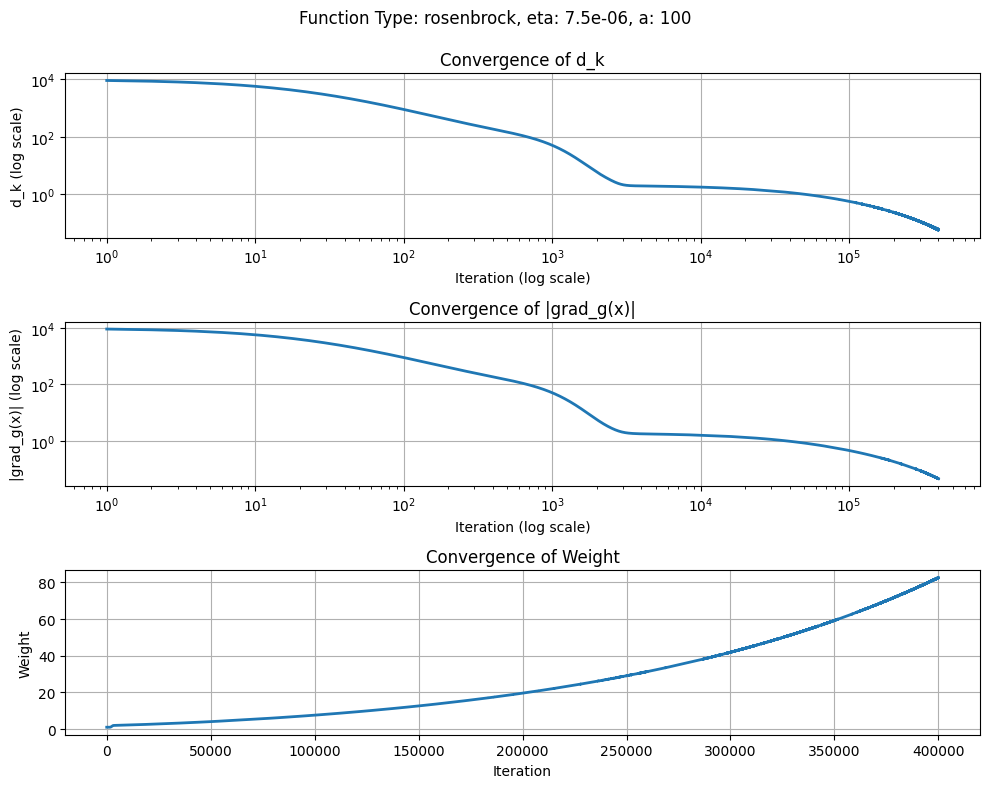

In [204]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3 ) = plt.subplots(3, 1, figsize=(10, 8))

# Plot f(x) in first subplot
ax1.loglog(time_values, d_values, linewidth=2)
ax1.set_xlabel('Iteration (log scale)')
ax1.set_ylabel('d_k (log scale)')
ax1.set_title('Convergence of d_k')
ax1.grid(True)

# Plot g(x) in second subplot
ax2.loglog(time_values, grad_g_norm_values, linewidth=2)
ax2.set_xlabel('Iteration (log scale)')
ax2.set_ylabel('|grad_g(x)| (log scale)')
ax2.set_title('Convergence of |grad_g(x)|')
ax2.grid(True)

ax3.plot(time_values, weight_vec, linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Weight')
ax3.set_title('Convergence of Weight')
ax3.grid(True)

# Add main title showing type and stepsize
plt.suptitle(f'Function Type: {g_type}, eta: {param["stepsize"]}, a: {a}', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for suptitle

# Show the plot
plt.show()